In [99]:
import json
import re
from pprint import pprint

import numpy as np
import pandas as pd
from IPython.core.display import HTML, display
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [100]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer(language = 'russian')

In [103]:
stop = stopwords.words('russian')
# удаляем из списка стоп слов  'не'
stop.remove('не')

# функция удаления стоп слов 
def replace_stop(string):
    mas = string.split()
    for i in stop:
        while i in mas :
            mas.remove(i)
    string  = ' '.join(mas)
    return string

In [104]:
# Функция приведения слова к нормальному виду
def norm(s):
    s = s.split()
    s = map(stemmer.stem, s)
    return ' '.join(s)

# Загрузка данных и анализ

In [252]:
train = pd.read_csv("/Users/apple/Downloads/train.csv", index_col = 0)
print(f"Размер: {train.shape=}\n")
print("Типы столбцов: ")
display(train.dtypes)
print("Фрагмент данных: ")
display(train.head())

Размер: train.shape=(19361, 4)

Типы столбцов: 


sentence     object
1category    object
2category    object
sentiment    object
dtype: object

Фрагмент данных: 


,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,NaN,+
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
11640,Отвратительное отношение к клиентам.,Communication,NaN,−
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+


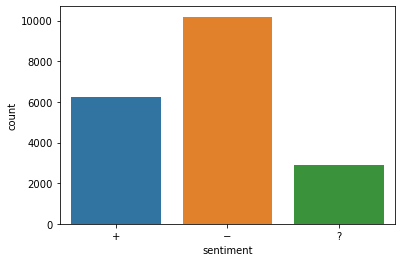

In [106]:
sns.countplot(train['sentiment'])
plt.show()

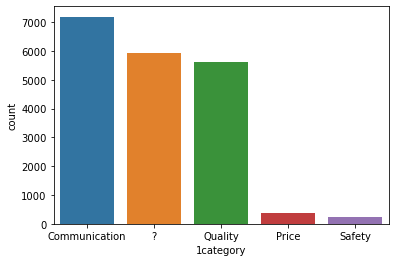

In [107]:
sns.countplot(train['1category'])
plt.show()

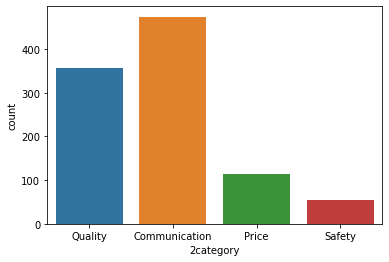

In [108]:
sns.countplot(train['2category'])
plt.show()

# Предобработка

In [253]:
# Удаление стоп слов и знаков препинаия,нижний регистр, нормальный вид
patt = re.compile("[^\w\s]")
train.loc[:, "sentence"] = train["sentence"].str.replace(
    patt, " ", regex=True
).map(str.lower).apply(replace_stop).apply(norm)

train

,sentence,1category,2category,sentiment
4754,получа качествен услуг,Communication,NaN,+
4417,не виж хот 2 постав сервис 1,?,NaN,−
3629,любим банк мкб обманул,?,NaN,−
11640,отвратительн отношен клиент,Communication,NaN,−
5571,люб врем дня ноч помогут ответ решат,Communication,NaN,+
...,...,...,...,...
8004,ко случа не открыва счет недостойн довер банк ...,Communication,NaN,−
18182,ти откровен заб качеств развива сво мег классн...,Quality,NaN,−
744,счита эт прор лидерств финансов услуг не центр...,?,NaN,+
6220,писа мужчин очен доходчив не финансов язык раб...,Communication,NaN,+


# Модели 

In [110]:
import sklearn.model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB

In [112]:
new_train = train

In [113]:
# Векоризация предложения
X, y = new_train['sentence'], new_train["sentiment"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X = X.toarray()
# Раздление на тетс и трейн
X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=0.8,
        test_size=0.2,
        
        )

## NB

In [114]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
prediction_test_targets = gnb.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, gnb.predict_proba(X_test), multi_class = 'ovr'))

accuracy  0.6090885618383682
roc  0.7510513036900418


## ЛОГ

In [115]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
prediction_test_targets = classifier.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class = 'ovr'))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy  0.8683191324554609
roc  0.9360105483924616


## MNB

In [116]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(force_alpha=True)
clf.fit(X_train, y_train)
prediction_test_targets = clf.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, clf.predict_proba(X_test), multi_class = 'ovr'))

accuracy  0.8352698166795766
roc  0.9159893069565386


## MLP

In [117]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
prediction_test_targets = classifier.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class = 'ovr'))

accuracy  0.8698683191324554
roc  0.9301878321964332


# Категории

In [232]:
train = pd.read_csv("/Users/apple/Downloads/train.csv", index_col = 0)
train

,sentence,1category,2category,sentiment
4754,При этом всегда получал качественные услуги.,Communication,NaN,+
4417,"Не вижу, за что хотя бы 2 поставить, сервис на 1!",?,NaN,−
3629,"Вот так ""Мой любимый"" банк МКБ меня обманул.",?,NaN,−
11640,Отвратительное отношение к клиентам.,Communication,NaN,−
5571,"Всегда в любое время дня и ночи помогут, ответ...",Communication,NaN,+
...,...,...,...,...
8004,Никогда и ни в коем случае не открывайте счет ...,Communication,NaN,−
18182,ТИ откровенно забили на качество и развивают с...,Quality,NaN,−
744,"Я считаю, это прорыв и лидерство финансовых ус...",?,NaN,+
6220,"Писал мужчина очень доходчиво, не финансовым я...",Communication,NaN,+


In [208]:
# Выбор заполненной второй категории
cat2 = train[['sentence', '2category' ]].dropna()
cat2.rename( columns={"2category": "1category"}, inplace = True)
cat2

,sentence,1category
13007,"Начну с того, что я пользовался и пользуюсь ус...",Quality
18828,Точка идеально походит для таких «чайников» ка...,Communication
19214,"Открывали счет 2 недели... Открыли, пока готов...",Price
19220,Итого что имеем обещанная ставка выросла более...,Price
18944,"Резюме: не ходите в Росбанк, он очень непорядо...",Communication
...,...,...
12378,Почему работают неквалифицированные специалист...,Quality
18821,Это реально круто.2) Очень грамотные менеджеры...,Communication
12593,"Ответа Банка я так и не получила, и, хуже того...",Safety
4600,* Удобство: 10 из 10* Работа сотрудников: 10 и...,Quality


In [254]:
cat1 = train[['sentence', '1category']]
cat1

,sentence,1category
4754,получа качествен услуг,Communication
4417,не виж хот 2 постав сервис 1,?
3629,любим банк мкб обманул,?
11640,отвратительн отношен клиент,Communication
5571,люб врем дня ноч помогут ответ решат,Communication
...,...,...
8004,ко случа не открыва счет недостойн довер банк ...,Communication
18182,ти откровен заб качеств развива сво мег классн...,Quality
744,счита эт прор лидерств финансов услуг не центр...,?
6220,писа мужчин очен доходчив не финансов язык раб...,Communication


In [255]:
# Соединение 
#cat = pd.concat([cat1,cat2])
cat = cat1

In [256]:
cat =  cat.sample(frac=1) 

X, y = cat['sentence'], cat["1category"]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)
X = X.toarray()

X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=0.8,
        test_size=0.2,
        
        )

In [223]:
y_test.index

Int64Index([ 5427,  9912, 11584, 13863,    21,   835, 15973,   287, 20636,
            16990,
            ...
            14643, 15172, 12018, 15195, 19334,  3437, 15654,   323, 11676,
            11018],
           dtype='int64', length=4072)

In [133]:
cat['1category'].unique()

array(['Communication', 'Quality', '?', 'Price', 'Safety'], dtype=object)

## MNB

In [258]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
prediction_test_targets = clf.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, clf.predict_proba(X_test), multi_class = 'ovr'))

accuracy  0.5830105861089595
roc  0.7816374755915038


In [215]:
proba = clf.predict_proba(X_test)

In [216]:
proba

array([[1.60798535e-02, 7.23907545e-02, 1.60063299e-04, 9.11365992e-01,
        3.33685170e-06],
       [3.68099774e-02, 9.34900697e-01, 1.06365506e-10, 2.82892954e-02,
        3.00538122e-08],
       [6.70220772e-03, 9.90361122e-01, 1.72701102e-08, 2.93665227e-03,
        8.45525697e-10],
       ...,
       [9.42499982e-01, 2.47560653e-03, 1.23918083e-05, 5.50111805e-02,
        8.39331837e-07],
       [4.50170739e-01, 1.57172194e-01, 6.42192407e-05, 3.92411155e-01,
        1.81692029e-04],
       [1.23684327e-02, 7.78922714e-01, 4.64570550e-09, 2.08708848e-01,
        2.25885848e-12]])

## MPL

In [237]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier()
classifier.fit(X_train, y_train)
prediction_test_targets = classifier.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class = 'ovr'))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


accuracy  0.5507358636715725
roc  0.7685767391633435


# LOG

In [257]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
prediction_test_targets = classifier.predict(X_test)
print('accuracy ',accuracy_score(y_test, prediction_test_targets))
print('roc ', roc_auc_score(y_test, classifier.predict_proba(X_test), multi_class = 'ovr'))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy  0.6018590240123934
roc  0.8235468159389516


In [247]:
import random

rand = random.choices(["Communication", "?", "Quality", "Price", "Safety"], k=len(y_test))

In [251]:
m = []
for i in range(1000):
    rand = random.choices(["Communication", "?", "Quality", "Price", "Safety"], k=len(y_test))
    m.append(sum(y_test == rand)/len(y_test))
np.mean(m)

0.1999078233927188

In [240]:
proba = classifier.predict_proba(X_test)

In [162]:
list(proba[:5])

[array([0.49570575, 0.32255377, 0.00333313, 0.09030694, 0.08810041]),
 array([1.28039572e-01, 3.83799964e-01, 1.98590621e-04, 4.86887203e-01,
        1.07467081e-03]),
 array([1.69260401e-01, 9.36293831e-02, 7.10064199e-04, 7.36309427e-01,
        9.07252877e-05]),
 array([7.49792115e-01, 1.06009084e-01, 1.61920999e-06, 1.44194526e-01,
        2.65591208e-06]),
 array([5.58654681e-05, 9.56176849e-01, 2.46152091e-10, 4.37672849e-02,
        2.54849294e-12])]

In [241]:
import copy
def fucntion(arr,limit):
    old_arr = copy.deepcopy(arr)
    new_arr = []
    for i in range(len(arr)):
        new_arr.append([old_arr[i].index(max(old_arr[i]))])
        old_arr[i].insert(old_arr[i].index(max(old_arr[i])),0)
        old_arr[i].remove(max(old_arr[i]))
        if max(old_arr[i])>=limit:
            new_arr[i].append(old_arr[i].index(max(old_arr[i])))
    return new_arr

In [242]:
test_proba=copy.deepcopy(proba)

In [219]:
test_proba.tolist()

[[0.016079853459594163,
  0.07239075446070774,
  0.00016006329868614217,
  0.9113659919293136,
  3.3368517008902264e-06],
 [0.03680997738353848,
  0.9349006970435072,
  1.0636550560395763e-10,
  0.028289295412780163,
  3.005381216147928e-08],
 [0.006702207721424548,
  0.9903611218918743,
  1.7270110190769042e-08,
  0.002936652271071094,
  8.455256965632737e-10],
 [0.34616523366321256,
  0.009626833240948117,
  0.01279330840938209,
  0.6314127343921151,
  1.8902943353425008e-06],
 [0.8255726664297016,
  0.11961240404892837,
  3.054855518993253e-05,
  0.05477189339234268,
  1.2487573837534767e-05],
 [0.8776645995534804,
  0.02805015322892627,
  0.007574709531048063,
  0.08627449073419009,
  0.00043604695235704364],
 [0.9998292430152544,
  5.8534630653618085e-05,
  6.122821346085895e-05,
  4.591405950826011e-05,
  5.080081123115224e-06],
 [0.0012246928515342013,
  0.9974144502111937,
  1.9208400572482805e-10,
  0.001360856679142179,
  6.605256500522606e-11],
 [0.9088322341240193,
  0.0755

In [183]:
test_proba

array([[4.95705750e-01, 3.22553766e-01, 3.33313130e-03, 9.03069447e-02,
        8.81004075e-02],
       [1.28039572e-01, 3.83799964e-01, 1.98590621e-04, 4.86887203e-01,
        1.07467081e-03],
       [1.69260401e-01, 9.36293831e-02, 7.10064199e-04, 7.36309427e-01,
        9.07252877e-05],
       ...,
       [1.87155554e-04, 9.99641746e-01, 1.70091069e-06, 1.69343515e-04,
        5.38018140e-08],
       [2.54737669e-02, 9.15235551e-01, 2.56052154e-07, 5.92902524e-02,
        1.73790257e-07],
       [1.71504072e-01, 4.90853898e-01, 2.03628821e-05, 3.37617774e-01,
        3.89275091e-06]])

In [243]:
d = fucntion(test_proba.tolist(),0.1)

In [244]:
d

[[1, 3],
 [0],
 [1, 0],
 [3, 0],
 [0],
 [3],
 [0],
 [3, 0],
 [1],
 [1],
 [1, 3],
 [0],
 [3],
 [1],
 [1],
 [1, 0],
 [3, 0],
 [1],
 [0, 1],
 [3, 0],
 [1, 0],
 [3, 0],
 [3, 0],
 [0],
 [1, 3],
 [0],
 [1, 0],
 [0],
 [0, 1],
 [1, 0],
 [1],
 [3, 0],
 [1, 0],
 [0, 1],
 [0],
 [0, 1],
 [3, 1],
 [4, 0],
 [0, 3],
 [3],
 [1],
 [3],
 [0, 3],
 [1],
 [3],
 [0, 3],
 [3, 1],
 [1, 3],
 [3, 0],
 [1],
 [0, 1],
 [3],
 [1, 0],
 [3, 0],
 [0, 1],
 [0, 1],
 [0],
 [0, 3],
 [1, 0],
 [0, 1],
 [1],
 [0, 1],
 [0, 1],
 [0, 3],
 [1, 0],
 [0, 1],
 [1, 0],
 [1],
 [2, 3],
 [3],
 [1, 3],
 [1, 0],
 [0],
 [1],
 [0, 1],
 [0],
 [1, 0],
 [1, 3],
 [0, 3],
 [4],
 [2, 3],
 [0, 3],
 [1, 0],
 [3, 1],
 [1, 3],
 [0, 3],
 [1, 0],
 [1, 3],
 [0, 1],
 [3],
 [1, 3],
 [3, 0],
 [3, 1],
 [3],
 [1, 3],
 [0],
 [3],
 [0, 1],
 [1, 0],
 [0],
 [0, 3],
 [1, 3],
 [3],
 [1, 3],
 [1],
 [1, 3],
 [0, 3],
 [3, 0],
 [3, 1],
 [1],
 [1],
 [0],
 [1, 3],
 [1],
 [1],
 [3, 0],
 [3, 1],
 [0, 1],
 [3, 0],
 [0, 3],
 [0],
 [0],
 [3],
 [1],
 [1],
 [0, 1],
 [1],
 [3,

In [245]:
a = train.merge(pd.DataFrame(data = d, index =  y_test.index), left_index = True, right_index = True, how = 'right')

In [246]:
a[a['1category'] != '?']

,sentence,1category,2category,sentiment,0,1
17551,Форменное безобразие и полное наплевательское ...,Quality,NaN,−,1,3.0
18106,"Сидя на колючих диванах этого ""супер-пупер"" оф...",Quality,NaN,−,3,0.0
17491,"Полный бред, почему нельзя закрыть договор в р...",Quality,NaN,−,3,NaN
8039,Никогда не связывайтеся с этим кошмарным завед...,Communication,NaN,−,0,NaN
8298,Приехав сегодня 4.06.2018 в это же отделение д...,Communication,NaN,−,1,NaN
...,...,...,...,...,...,...
8687,Если кто просрочит платёж по кредиту каждый де...,Communication,NaN,−,1,NaN
9915,"Значит, новые обращения вообще не читают.",Communication,NaN,−,1,3.0
8669,"Очень надеюсь, что руководство Сбербанка обрат...",Communication,NaN,−,0,3.0
4922,Удачи и процветания Вам и Вашему коллективу,Communication,NaN,+,0,1.0
